In [4]:
import pandas as pd
import numpy as np
import glob
from collections import Counter
from nltk.corpus import stopwords
import os, sys, re, json, time, unittest
import itertools, collections
from scipy import stats
from subprocess import call
import nltk
from shared_lib import utils, vocabulary
from shared_lib import ngram_lm
from shared_lib import ngram_utils
from shared_lib import simple_trigram
import matplotlib.pyplot as plt
import datetime
import sys
# sys.setdefaultencoding('utf-8')

In [5]:
reload(utils)

<module 'shared_lib.utils' from 'shared_lib/utils.pyc'>

# Download Data

In [3]:
reload(utils)
utils.download_tweets('2012-10-', 'New York City', 1, 30, 2000)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/cloudera/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/cloudera/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/cloudera/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/cloudera/anaconda2/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/cloudera/anaconda2/lib/python2.7/inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/cloudera/anaconda2/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader

IndexError: string index out of range

# Data Preparation

In [71]:
train_bin_size = 14
test_bin_size = 1

vegas_directory = 'data/data_Las_Vegas'
houston_directory = 'data/data_Houston'
san_juan_directory = 'data/data_San_Juan'
nyc_directory = 'data/data_New_York_City'
miami_directory = 'data/data_Miami'
boston_directory = 'data/data_Boston'
data_directories = [vegas_directory, houston_directory, san_juan_directory, miami_directory, nyc_directory, boston_directory]

In [72]:
def get_train_and_tests(directory, train_size=21, test_size=3):
    allFiles = sorted(glob.glob(directory + "/*.csv"))
    train_frame = pd.DataFrame()
    train_list = []
    tests_list = []
    test_list = []
    tweet_column = 'text'
    test_files = []
    tests_files = []
    for index, file_ in enumerate(allFiles):
        df = pd.read_csv(file_,index_col=None, header=0, delimiter=';', error_bad_lines=False)
        if index < train_bin_size:
            #print "Adding {0} to training with {1} lines.".format(file_, len(df))
            train_list.append(df[tweet_column])
        elif (index + 1 - train_bin_size) % test_bin_size == 0:
            #print "Adding {0} to testing with {1} lines.".format(file_, len(df))
            test_list.append(df[tweet_column])
            test_files.append(file_)
            test_set = pd.concat(test_list, ignore_index=True).dropna()
            #print "Adding a test set to training with {0} lines.".format(len(test_set))
            tests_list.append(test_set)
            tests_files.append(test_files)
            test_list=[]
            test_files=[]
        else:
            #print "Adding {0} to testing with {1} lines.".format(file_, len(df))
            test_list.append(df[tweet_column])
            test_files.append(file_)

    train_frame = pd.concat(train_list, ignore_index=True).dropna()
    return (train_frame, tests_list, tests_files)

In [73]:
vegas_train, vegas_tests, vegas_test_files = utils.get_train_and_tests(vegas_directory, train_size=train_bin_size, test_size=test_bin_size)
houston_train, houston_tests, houston_test_files = utils.get_train_and_tests(houston_directory, train_size=train_bin_size, test_size=test_bin_size)
san_juan_train, san_juan_tests, san_juan_test_files = utils.get_train_and_tests(san_juan_directory, train_size=train_bin_size, test_size=test_bin_size)
miami_train, miami_tests, miami_test_files = utils.get_train_and_tests(miami_directory, train_size=train_bin_size, test_size=test_bin_size)
nyc_train, nyc_tests, nyc_test_files = utils.get_train_and_tests(nyc_directory, train_size=train_bin_size, test_size=test_bin_size)
boston_train, boston_tests, boston_test_files = utils.get_train_and_tests(boston_directory, train_size=train_bin_size, test_size=test_bin_size)


Skipping line 1755: expected 10 fields, saw 11

Skipping line 239: expected 10 fields, saw 11
Skipping line 1644: expected 10 fields, saw 11

Skipping line 296: expected 10 fields, saw 11

Skipping line 70: expected 10 fields, saw 11

Skipping line 489: expected 10 fields, saw 11

Skipping line 13: expected 10 fields, saw 11

Skipping line 644: expected 10 fields, saw 11

Skipping line 1105: expected 10 fields, saw 11

Skipping line 276: expected 10 fields, saw 11
Skipping line 1476: expected 10 fields, saw 11

Skipping line 425: expected 10 fields, saw 12

Skipping line 579: expected 10 fields, saw 11

Skipping line 987: expected 10 fields, saw 11

Skipping line 974: expected 10 fields, saw 11

Skipping line 846: expected 10 fields, saw 11

Skipping line 336: expected 10 fields, saw 11

Skipping line 706: expected 10 fields, saw 11

Skipping line 357: expected 10 fields, saw 11

Skipping line 687: expected 10 fields, saw 11
Skipping line 880: expected 10 fields, saw 11

Skipping line 

In [9]:
vegas_train.head()

0    Congratulations to Mr. & Mrs. Clifford! Anothe...
1    #cloudwatcherextraordinaire @Las Vegas, Nevada...
2    We made a #realtor very happy with our #homest...
3    #Sammich with #flaminghotcheetos spread #lasve...
4    clear sky -> few clouds temperature up 91°F ->...
Name: text, dtype: object

## Filtering

In [30]:
import string
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords

#Sanitizes the text by removing front and end punctuation, 
#making words lower case, and removing any empty strings.
def get_text_sanitized(tweet):
    return ' '.join([w.lower().strip().rstrip(string.punctuation)\
        .lstrip(string.punctuation).strip()\
        for w in tweet.replace('\xe2\x80\xa6', '').split(" ")\
        if w.strip().rstrip(string.punctuation).strip()])

#Gets the text, clean it, make it lower case, stem the words, and split
#into a vector. Also, remove stop words.
def get_text_normalized(tweet):
    #Sanitize the text first.
    text = get_text_sanitized(tweet).split()
    
    #Remove the stop words.
    text = [t for t in text if t not in [stopwords.words('english')] ]

    return text
    
    #Stemmer gets upset at a lot of tweets
    #Create the stemmer.
    stemmer = LancasterStemmer()
    
    #Stem the words.
    return [stemmer.stem(t) for t in text]

def purge_urls(tweet):
    return re.sub('http[s]?://(www. )?(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)

def sanitize_dataset(dataset):
    sentences = []
    for sentence in dataset:
        sentences.append(get_text_normalized(purge_urls(sentence)))
    return sentences

# Trigram Model

In [31]:
def get_vocab_size(sentences):
    results = Counter()
    for sent in sentences:
        results.update(sent)
    return len(results)

In [32]:
def sents_to_tokens(vocab, sents):
    """Returns an flattened list of the words in the sentences, with padding for a trigram model."""
    padded_sentences = (["<s>", "<s>"] + s + ["</s>"] for s in sents)
    # This will canonicalize words, and replace anything not in vocab with <unk>
    return np.array([utils.canonicalize_word(w, wordset=vocab.wordset) 
                     for w in utils.flatten(padded_sentences)], dtype=object)

In [33]:
def build_model(train_tokens, addk=False, k=0.001, delta=0.75):
    # Uncomment the line below for the model you want to run.
    Model = ngram_lm.KNTrigramLM
    if addk:
        Model = ngram_lm.AddKTrigramLM
    t0 = time.time()
    print "Building trigram LM...",
    lm = Model(train_tokens)
    print "done in %.02f s" % (time.time() - t0)
    ngram_utils.print_stats(lm)
    lm.set_live_params(k = 0.001, delta=0.75)
    return lm

In [34]:
def get_perplexity(lm, tokens, train_or_test="Test"):
    #log_p_data, num_real_tokens = ngram_utils.score_seq(lm, train_tokens)
    #print "Train perplexity: %.02f" % (2**(-1*log_p_data/num_real_tokens))
    log_p_data, num_real_tokens = ngram_utils.score_seq(lm, tokens)
    perplexity = -1.0
    if num_real_tokens > 0:
        perplexity = (2**(-1*log_p_data/num_real_tokens))
    print "{0} perplexity: {1:.2f}".format(train_or_test, perplexity)
    return perplexity

In [35]:
def measure_perplexity_over_time(train_set, test_sets, test_files, addk=False):
    train_sents = sanitize_dataset(train_set)
    vocab = vocabulary.Vocabulary((utils.canonicalize_word(w) for w in utils.flatten(train_sents)), size=get_vocab_size(train_sents), unknown_size=500)
    print "Train set vocabulary: %d words" % vocab.size
    train_tokens = sents_to_tokens(vocab, train_sents)
    lm = build_model(train_tokens, addk)
    get_perplexity(lm, train_tokens, "Train")
    perplexities = []
    for idx, test_set in enumerate(test_sets):
        print "="*20
        print "Test set #{0} containing files:\n{1}".format(idx, test_files[idx])
        test_sents = sanitize_dataset(test_set)
        test_tokens = sents_to_tokens(vocab, test_sents)
        perplexities.append(get_perplexity(lm, test_tokens))
        print "="*20
    return perplexities

In [74]:
reload(utils)
vegas_perplexities_kn = utils.measure_perplexity_over_time(vegas_train, vegas_tests, vegas_test_files, addk=False)
houston_perplexities_kn = utils.measure_perplexity_over_time(houston_train, houston_tests, houston_test_files, addk=False)
san_juan_perplexities_kn = utils.measure_perplexity_over_time(san_juan_train, san_juan_tests, san_juan_test_files, addk=False)
miami_perplexities_kn = utils.measure_perplexity_over_time(miami_train, miami_tests, miami_test_files, addk=False)
nyc_perplexities_kn = utils.measure_perplexity_over_time(nyc_train, nyc_tests, nyc_test_files, addk=False)
boston_perplexities_kn = utils.measure_perplexity_over_time(boston_train, boston_tests, boston_test_files, addk=False)

Train set vocabulary: 14324 words
Building trigram LM... done in 0.82 s
=== N-gram Language Model stats ===
14324 unique 1-grams
46865 unique 2-grams
63951 unique 3-grams
Optimal memory usage (counts only): 2 MB
Train perplexity: 6.96
Test set #0 containing files:
['data/data_Las_Vegas/2017-09-24.csv']
Test perplexity: 222.55
Test set #1 containing files:
['data/data_Las_Vegas/2017-09-25.csv']
Test perplexity: 172.30
Test set #2 containing files:
['data/data_Las_Vegas/2017-09-26.csv']
Test perplexity: 242.13
Test set #3 containing files:
['data/data_Las_Vegas/2017-09-27.csv']
Test perplexity: 223.11
Test set #4 containing files:
['data/data_Las_Vegas/2017-09-28.csv']
Test perplexity: 126.41
Test set #5 containing files:
['data/data_Las_Vegas/2017-09-29.csv']
Test perplexity: 204.10
Test set #6 containing files:
['data/data_Las_Vegas/2017-09-30.csv']
Test perplexity: -1.00
Test set #7 containing files:
['data/data_Las_Vegas/2017-10-01.csv']
Test perplexity: 243.62
Test set #8 containing

In [75]:
all_perplexities = []
all_perplexities.append(vegas_perplexities_kn)
all_perplexities.append(houston_perplexities_kn)
all_perplexities.append(san_juan_perplexities_kn)
all_perplexities.append(miami_perplexities_kn)
all_perplexities.append(nyc_perplexities_kn)
all_perplexities.append(boston_perplexities_kn)

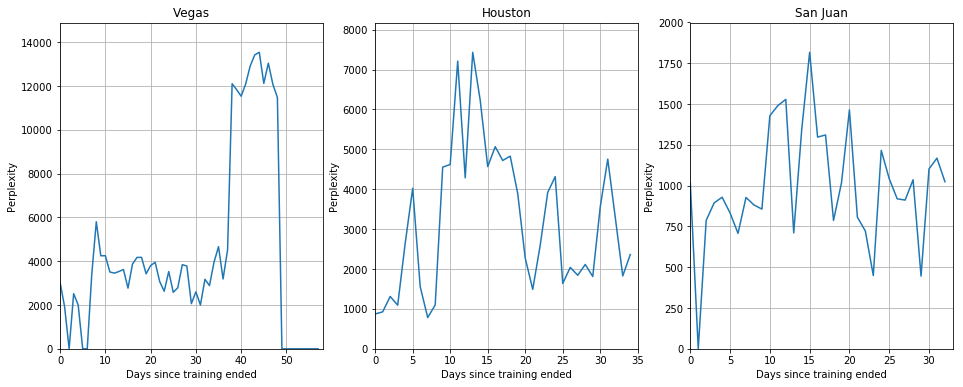

In [24]:
plt.figure(figsize=(16, 6))
events = ['Vegas', 'Houston', 'San Juan']
for i in range(len(events)):
    plt.subplot(131 + i)
    perp = all_perplexities[i]
    plt.plot(perp)
    plt.title(events[i])
    plt.ylabel('Perplexity')
    plt.axis([0, len(perp), 0, 1.1 * max(perp)])
    plt.gca().set_xlabel("Days since training ended")
    plt.grid()
plt.show()

In [25]:
plt.figure(figsize=(16, 6))
events = ['Vegas', 'Houston', 'San Juan']
tests = [vegas_tests, houston_tests, san_juan_tests]
for i in range(len(events)):
    plt.subplot(131 + i)
    doc_count = [len(test_set) for test_set in tests[i]]
    plt.plot(doc_count)
    plt.title(locations[i])
    plt.ylabel('Tweets')
    plt.axis([0, len(doc_count), 0, 1.1 * max(doc_count)])
    plt.gca().set_xlabel("Days since training ended")
    plt.grid()
plt.show()

NameError: name 'locations' is not defined

I need to download more data for these various parts to make sure that the test data sizes aren't affecting things.

In [26]:
get_vocab_size(sanitize_dataset(vegas_train))
len(vegas_train)

6499

In [38]:
def get_entire_dataframe(directory):
    allFiles = sorted(glob.glob(directory + "/*.csv"))
    train_frame = pd.DataFrame()
    train_list = []
    for index, file_ in enumerate(allFiles):
        df = pd.read_csv(file_,index_col=None, header=0, delimiter=';', error_bad_lines=False)
        train_list.append(df)
    train_frame = pd.concat(train_list, ignore_index=True)
    return train_frame

In [39]:
# setup train data
def get_raw_text(df):
    raw_text = ''
    for post in df['text']:
        raw_text = ' '.join([raw_text, str(post).decode('utf-8')])
    return raw_text

def get_word_freq_by_day(df, start_date, end_date, search_word):    
    
    word_counts = []
    
    while start_date <= end_date:
        sample_df = df[(df['date'].dt.date == start_date)]

        raw_sample_text = get_raw_text(sample_df)
        sample_words_list = nltk.word_tokenize(raw_sample_text)

        sample_vocab = vocabulary.Vocabulary((utils.canonicalize_word(w) for w in sample_words_list))

        word_counts.append([start_date, sample_vocab.unigram_counts[search_word]])

        start_date += datetime.timedelta(days=1)
    
    return word_counts

def assign_days_to_perplexities(perplexities, start_date, end_date):
    dated_perplexities = []
    dayCnt = 0
    while start_date <= end_date and dayCnt < len(perplexities):
        
        dated_perplexities.append([start_date, perplexities[dayCnt]])
        start_date += datetime.timedelta(days=1)
        dayCnt += 1
    
    return dated_perplexities

## Final Analysis Plots

In [76]:
words = [['shooting', 'mandalay', 'violence'],['hurricane', 'storm', 'harvey'], ['hurricane', 'storm', 'maria'], ['hurricane', 'storm', 'irma'], ['hurricane', 'storm', 'sandy'], ['explosion', 'bomb']]
# Including training
#dates = [[datetime.date(2017, 9, 10), datetime.date(2017, 11, 12)], [datetime.date(2017, 8, 1), datetime.date(2017, 9, 20)], [datetime.date(2017, 9, 1), datetime.date(2017, 10, 19)], [datetime.date(2017, 8, 4), datetime.date(2017, 9, 29)], [datetime.date(2012, 10, 1), datetime.date(2012, 11, 29)], [datetime.date(2013, 3, 20), datetime.date(2013, 5, 15)]]

# Not including training
dates = [[datetime.date(2017, 9, 25), datetime.date(2017, 11, 11)], [datetime.date(2017, 8, 15), datetime.date(2017, 9, 20)], [datetime.date(2017, 9, 15), datetime.date(2017, 10, 19)], [datetime.date(2017, 8, 18), datetime.date(2017, 9, 29)], [datetime.date(2012, 10, 15), datetime.date(2012, 11, 29)], [datetime.date(2013, 4, 4), datetime.date(2013, 4, 30)]]

events = ['Las Vegas', 'Houston', 'San Juan', 'Miami', 'New York City', 'Boston']
# fig, ax = plt.subplots(1, len(data_directories)*2, figsize=(14, 5))
figs = []
for i in range(len(data_directories)):
    data_directory = data_directories[i]
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Perplexity Plot
    perps = assign_days_to_perplexities(all_perplexities[i], dates[i][0], dates[i][1])
    ax[0].plot(*zip(*perps))   
    ax[0].set_title('{0} perplexity'.format(events[i]))
    ax[0].set_ylabel('perplexity')
    ax[0].set_xlabel('time')
    #ax[0].legend()

    
    # Word count plot
    
    word_counts = {}
    frame = get_entire_dataframe(data_directory)
    frame['date'] = pd.to_datetime(frame['date'], errors='coerce')
    for word in words[i]:
        word_counts[word] = get_word_freq_by_day(frame, dates[i][0], dates[i][1], word)

    for key in word_counts.keys():
        ax[1].plot(*zip(*word_counts[key]), label=key)
    ax[1].set_title(data_directory.replace('data_', '').replace('_', ' ').replace('data/','') + ' word freq')
    ax[1].set_ylabel('frequency')
    ax[1].set_xlabel('time')
    ax[1].legend()

    fig.autofmt_xdate()
    figs.append(fig)

Skipping line 1755: expected 10 fields, saw 11

Skipping line 239: expected 10 fields, saw 11
Skipping line 1644: expected 10 fields, saw 11

Skipping line 296: expected 10 fields, saw 11

/home/cloudera/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
Skipping line 70: expected 10 fields, saw 11

Skipping line 489: expected 10 fields, saw 11

Skipping line 13: expected 10 fields, saw 11

Skipping line 644: expected 10 fields, saw 11

Skipping line 1105: expected 10 fields, saw 11

Skipping line 276: expected 10 fields, saw 11
Skipping line 1476: expected 10 fields, saw 11

Skipping line 425: expected 10 fields, saw 12

Skipping line 579: expected 10 fields, saw 11

Skipp

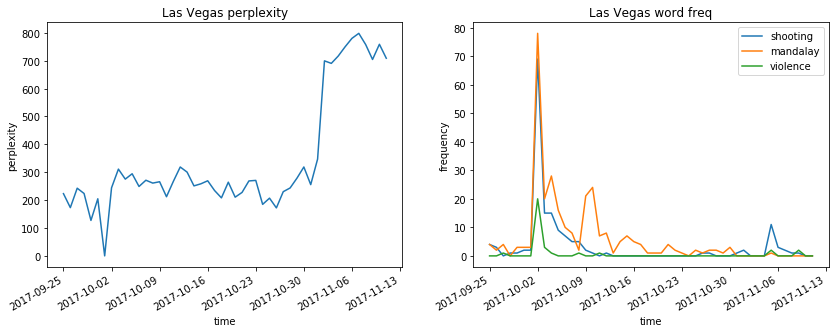

In [77]:
figs[0]

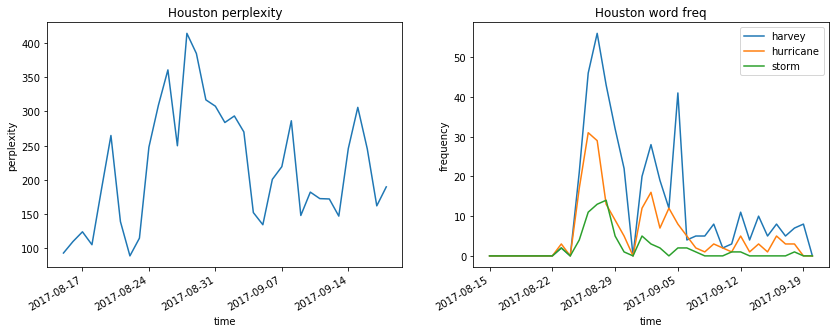

In [78]:
figs[1]

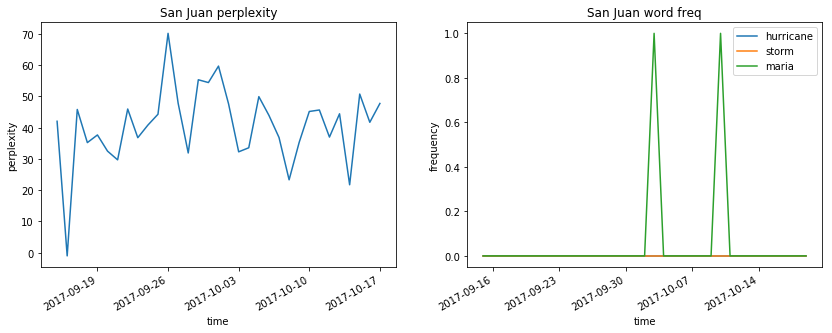

In [79]:
figs[2]

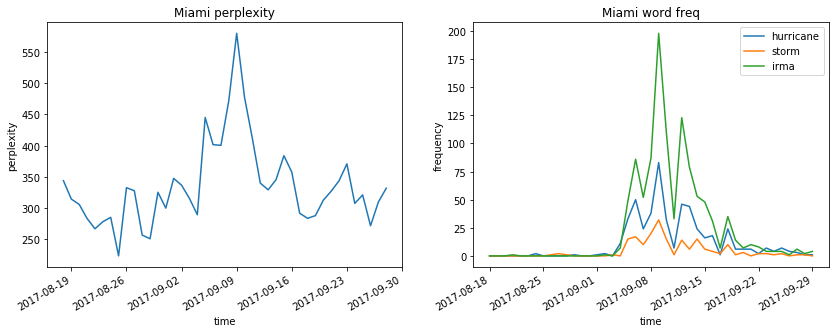

In [80]:
figs[3]

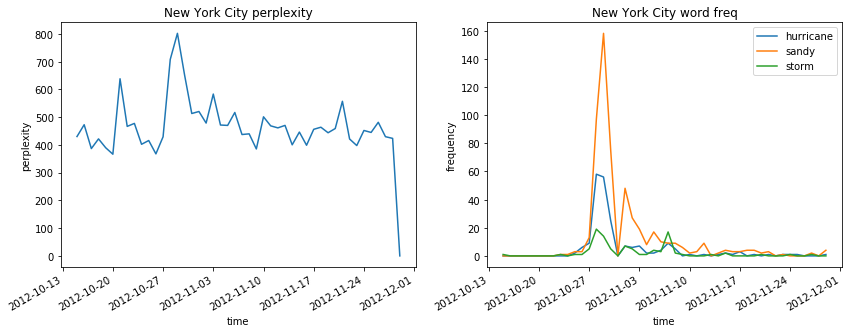

In [81]:
figs[4]

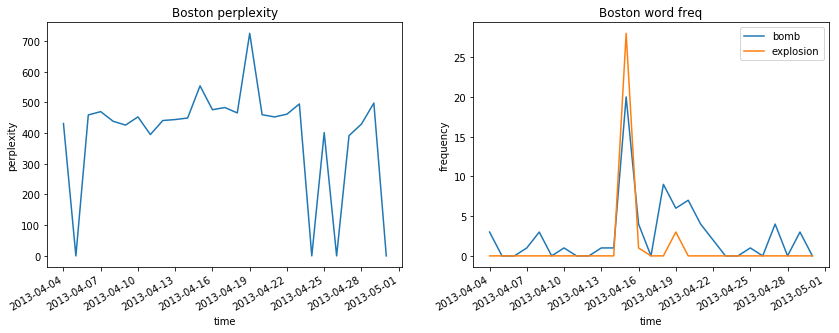

In [82]:
figs[5]

Skipping line 1755: expected 10 fields, saw 11

Skipping line 239: expected 10 fields, saw 11
Skipping line 1644: expected 10 fields, saw 11

Skipping line 296: expected 10 fields, saw 11

/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
Skipping line 70: expected 10 fields, saw 11

Skipping line 489: expected 10 fields, saw 11

Skipping line 13: expected 10 fields, saw 11



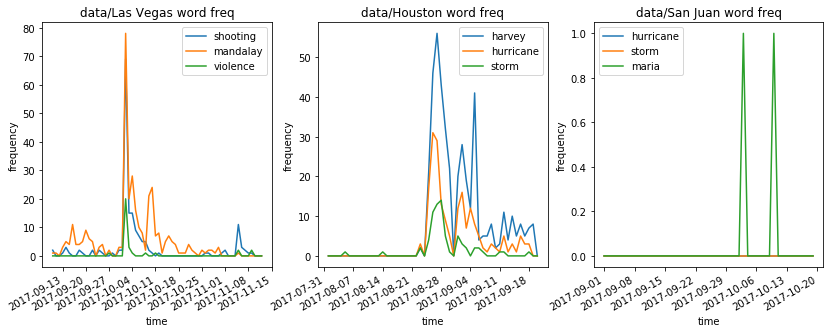

In [55]:
words = [['shooting', 'mandalay', 'violence'],['hurricane', 'storm', 'harvey'], ['hurricane', 'storm', 'maria']]
dates = [[datetime.date(2017, 9, 10), datetime.date(2017, 11, 12)], [datetime.date(2017, 8, 1), datetime.date(2017, 9, 20)], [datetime.date(2017, 9, 1), datetime.date(2017, 10, 19)]]
fig, ax = plt.subplots(1, len(data_directories)*2, figsize=(14, 5))
for i in range(0, len(data_directories)*2, 2):
    data_directory = data_directories[i]
    
    
    
        ax[i].set_title(data_directory.replace('data_', '').replace('_', ' ') + ' word freq')
    ax[i].set_ylabel('frequency')
    ax[i].set_xlabel('time')
    ax[i].legend()
    
    plt.subplot(121)
plt.plot(all_perplexities[current_index])
plt.title(events[current_index])
plt.ylabel('Perplexity')
plt.axis([0, len(all_perplexities[current_index]), 0, 1.1 * max(all_perplexities[current_index])])
plt.gca().set_xlabel("Days since training ended")
plt.grid()
    
    
    
    
    frame = get_entire_dataframe(data_directory)
    
    
    
    
    
    word_counts = {}
    frame['date'] = pd.to_datetime(frame['date'], coerce=True)
    for word in words[i]:
        word_counts[word] = get_word_freq_by_day(frame, dates[i][0], dates[i][1], word)
    
    for key in word_counts.keys():
        ax[i].plot(*zip(*word_counts[key]), label=key)
    ax[i].set_title(data_directory.replace('data_', '').replace('_', ' ') + ' word freq')
    ax[i].set_ylabel('frequency')
    ax[i].set_xlabel('time')
    ax[i].legend()

fig.autofmt_xdate()
fig